In [14]:
import gym
import gym_mnist
import tensorflow as tf
import logging
from model import EnvModel
from modellearner import ModelLearner
from utils.dataset import iterbatches
import configs
import numpy as np
from utils.latent_visualizer import LatentVisualizer
from utils.getch import getch
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss, normalized_mutual_info_score as nmi_score
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


logdir_base = 'data/experiments/complex_varying_horizon//'
#logdir_dict = {'$\lambda_c=$' + suffix[8:] : os.path.join(logdir_base, suffix) for suffix in os.listdir(logdir_base)}
logdir_dict = {suffix[8:] : os.path.join(logdir_base, suffix) for suffix in os.listdir(logdir_base)}
#logdir_dict['wfeatures'] = 'data/experiments/linear_wfeat_wgb/'

clustering_score_dict = {}
goal_score_dict = {}
replay_memories = False
num_evaluation_batches = 100
max_val_steps = 20
basename = 'complex_lenvarying_'

In [15]:
env = gym.make('mnist-v0')
config = configs.load_config(list(logdir_dict.values())[0])
tf.reset_default_graph()
ml = ModelLearner(env, config)
ml.gather_gameplay_data(num_games=3000)
transition_datasets = [ml.create_transition_dataset(max_steps=i, variable_steps=False) for i in range(1, max_val_steps+1)]
#uncomment lines to cause all episodes to start at 5
#inds = [i for i in range(transition_dataset[0].shape[0]) if transition_dataset[-1][i, 0] == 5]
#transition_dataset = [arr[inds] for arr in transition_dataset]
logger.info("Gameplay data gathered.")

[2017-08-03 10:08:37,133] Making new env: mnist-v0
Exception ignored in: <bound method MNISTEnv.__del__ of <gym_mnist.envs.mnist_env.MNISTEnv object at 0x7f82dc35dd68>>
Traceback (most recent call last):
  File "/home/yonadav/tensorflow/lib/python3.4/site-packages/gym/core.py", line 203, in __del__
    self.close()
  File "/home/yonadav/tensorflow/lib/python3.4/site-packages/gym/core.py", line 164, in close
    self.render(close=True)
  File "/home/yonadav/tensorflow/lib/python3.4/site-packages/gym/core.py", line 150, in render
    return self._render(mode=mode, close=close)
  File "/home/yonadav/Experiments/model-based/gym_mnist/gym_mnist/envs/mnist_env.py", line 91, in _render
    cv2.destroyWindow('game')
cv2.error: /io/opencv/modules/highgui/src/window.cpp:571: error: (-2) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in functi

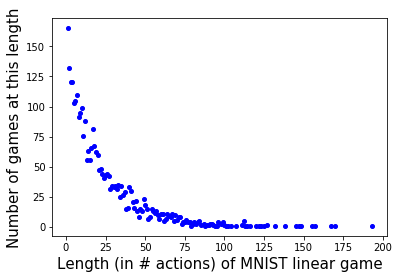

In [ ]:
lengths = {}
for game in ml.replay_memory:
    if len(game) in lengths.keys():
        lengths[len(game)] += 1
    else:
        lengths[len(game)] = 1

plt.plot(list(lengths.keys()), list(lengths.values()),'bo', markersize=4)
plt.xlabel('Length (in # actions) of MNIST linear game', size=15)
plt.ylabel('Number of games at this length', size=15)
plt.savefig(os.path.join("figures/",basename + 'gamelengths.svg'))
plt.savefig(os.path.join("figures/",basename + 'gamelengths.png'))

In [ ]:
for logname, logdir in logdir_dict.items():
    config = configs.load_config(logdir)
    tf.reset_default_graph()
    ml = ModelLearner(env, config)
    envmodel = ml.envmodel
    from utils.latest_checkpoint_unsafe import latest_checkpoint
    restore_path = latest_checkpoint(logdir)
    var_dict = {var.name[:-2]: var for var in tf.global_variables()}
    restoring_saver = tf.train.Saver(var_list=var_dict)

    with tf.Session() as sess:
        if restore_path is not None:
            logger.info("Restoring variables from checkpoint: {}".format(restore_path))
            restoring_saver.restore(sess, restore_path)
        else:
            logger.info("Initializing brand new network parameters.")
            sess.run(tf.global_variables_initializer())

        goal_scores = []
        for stepind in range(1, max_val_steps+1):
            transition_dataset = transition_datasets[stepind - 1]
            iterb = iterbatches(transition_dataset, batch_size=envmodel.test_batchsize)
            latent_size = config['latent_size']

            states_full = np.zeros([0] + list(transition_dataset[0].shape[1:]))
            latents_full = np.zeros([0, stepind + 1, latent_size])
            labels_full = np.zeros([0, stepind + 1, 1])
            truegv_full = np.zeros([0, stepind])
            goalvalues_full = np.zeros([0, stepind])
            for _ in range(num_evaluation_batches):
                batch = next(iterb)
                states, actions, _, truegoalvalues, goalstates, _, truelabels = batch
                initial_states = states[:, 0]
                initial_latents = envmodel.encode(initial_states)
                _, future_latents = envmodel.stepforward(latent_state=initial_latents, actions=actions)
                goallatents = envmodel.encode(goalstates)
                goallatents_flattened = np.tile(np.expand_dims(goallatents, axis=1),
                                               [1, stepind, 1]).reshape([-1, latent_size])
                flattened_latents = future_latents.reshape([-1, latent_size])
                b = envmodel.test_batchsize
                n_values = flattened_latents.shape[0]
                goalvalues = []
                for i in range(n_values//b + 1):
                    lower = i*b
                    upper = min((i+1)*b, n_values)
                    latents_chunk = flattened_latents[lower:upper]
                    goalstates_chunk = goallatents_flattened[lower:upper]
                    goalvalues_chunk = envmodel.checkgoal(latents_chunk, goalstates_chunk)
                    goalvalues.append(goalvalues_chunk)
                goalvalues = np.concatenate(goalvalues, axis=0).reshape([b, stepind])
                initial_latents = np.expand_dims(initial_latents, axis=1)
                latents = np.concatenate([initial_latents, future_latents], axis=1)
                states_full = np.concatenate([states_full, states], axis=0)
                latents_full = np.concatenate([latents_full, latents], axis=0)
                labels_full = np.concatenate([labels_full, truelabels], axis=0)
                truegv_full = np.concatenate([truegv_full, truegoalvalues], axis=0)
                goalvalues_full = np.concatenate([goalvalues_full, goalvalues], axis=0)
            true_goalvalues = truegv_full[:, -1].astype(bool)
            goalvalues = goalvalues_full[:, -1]
            goal_score = log_loss(true_goalvalues, goalvalues, labels=[0, 1])
            print("Goal score: {}".format(goal_score))
            goal_scores.append(goal_score)
    
    # At this last timestep, the value remaining in all the "full" containers is for the full length, i.e. max_val_steps
    labels_full = np.squeeze(labels_full, axis=-1)
    kmeans_algorithm = KMeans(n_clusters=10, n_init=100)

    clustering_scores = []    
    for i in range(max_val_steps + 1):
        labels = labels_full[:, i]
        latents = latents_full[:, i]
        guessed_labels = kmeans_algorithm.fit_predict(latents)
        clustering_score = nmi_score(labels, guessed_labels)
        clustering_scores.append(clustering_score)
        print("Step {}: V score - {}".format(i, clustering_score))
    clustering_scores = np.asarray(clustering_scores)
    goal_scores = np.asarray(goal_scores)
    clustering_score_dict[logname] = clustering_scores
    goal_score_dict[logname] = goal_scores

[2017-08-03 10:10:40,476] Restoring variables from checkpoint: data/experiments/complex_varying_horizon//complex_4step/model.ckpt-4993872


INFO:tensorflow:Restoring parameters from data/experiments/complex_varying_horizon//complex_4step/model.ckpt-4993872


[2017-08-03 10:10:40,479] Restoring parameters from data/experiments/complex_varying_horizon//complex_4step/model.ckpt-4993872


Goal score: 0.0017990040206607748
Goal score: 0.012052846434508964
Goal score: 0.007186740113750872
Goal score: 0.012739568124321012
Goal score: 0.041799921483173325
Goal score: 0.1115783178459764
Goal score: 0.14031590354764792
Goal score: 0.1687509537611186
Goal score: 0.2098409481597004
Goal score: 0.21726981820018512
Goal score: 0.2550817310076979
Goal score: 0.27869705562812663
Goal score: 0.31184987528629093
Goal score: 0.34081960778955583
Goal score: 0.3383568494583716
Goal score: 0.36977531729885726
Goal score: 0.413424784483098
Goal score: 0.4357399636971071
Goal score: 0.4097280896852623
Goal score: 0.4241565904003037
Step 0: V score - 0.835621255588495
Step 1: V score - 0.3192814411497552
Step 2: V score - 0.12424830886163724
Step 3: V score - 0.11892131480979583
Step 4: V score - 0.15193306120994685
Step 5: V score - 0.1571547655945377
Step 6: V score - 0.1551211005788234
Step 7: V score - 0.13625867359493787
Step 8: V score - 0.12189996167979972
Step 9: V score - 0.1232428

[2017-08-03 10:14:48,306] Restoring variables from checkpoint: data/experiments/complex_varying_horizon//complex_8step/model.ckpt-4993872


INFO:tensorflow:Restoring parameters from data/experiments/complex_varying_horizon//complex_8step/model.ckpt-4993872


[2017-08-03 10:14:48,308] Restoring parameters from data/experiments/complex_varying_horizon//complex_8step/model.ckpt-4993872


Goal score: 0.026497743167891122
Goal score: 0.008797321748205824
Goal score: 0.011411308394436966
Goal score: 0.011645967368611863
Goal score: 0.005915452836275077
Goal score: 0.010741485902028385
Goal score: 0.012723324597653539
Goal score: 0.010494350378016612
Goal score: 0.021794694693389745
Goal score: 0.015065369942743444
Goal score: 0.025460174503865902
Goal score: 0.022364513684511353
Goal score: 0.037836399519480125
Goal score: 0.03157271182254114
Goal score: 0.0554667538868965
Goal score: 0.061003620474486826
Goal score: 0.08323805190333239
Goal score: 0.07412611374551993
Goal score: 0.08565343917898506
Goal score: 0.09704806624845644
Step 0: V score - 0.8039381649405283
Step 1: V score - 0.36280013556940255
Step 2: V score - 0.21174891678245164
Step 3: V score - 0.3693676702064355
Step 4: V score - 0.33673151054376627
Step 5: V score - 0.25716935356501225
Step 6: V score - 0.2597878005662156
Step 7: V score - 0.26581160728187514
Step 8: V score - 0.22736536816550193
Step 9: 

[2017-08-03 10:18:32,131] Restoring variables from checkpoint: data/experiments/complex_varying_horizon//complex_1step/model.ckpt-4995160


INFO:tensorflow:Restoring parameters from data/experiments/complex_varying_horizon//complex_1step/model.ckpt-4995160


[2017-08-03 10:18:32,132] Restoring parameters from data/experiments/complex_varying_horizon//complex_1step/model.ckpt-4995160


Goal score: 0.016993972710211542
Goal score: 0.47053086057161253
Goal score: 0.46579074209040483
Goal score: 0.5317530198273923
Goal score: 0.5461088184744187
Goal score: 0.4844732467515851
Goal score: 0.47500312384587384
Goal score: 0.47022197216460077
Goal score: 0.4159074908102742
Goal score: 0.38642927402476623
Goal score: 0.34374998785865885
Goal score: 0.29622345827755736
Goal score: 0.3523580711029934
Goal score: 0.3565995691554832
Goal score: 0.26619330221805476
Goal score: 0.2712130191069511
Goal score: 0.2575254865901653
Goal score: 0.2594571287633569
Goal score: 0.26071737995920946
Goal score: 0.26001299991548193
Step 0: V score - 0.662081442875282
Step 1: V score - 0.20605112717148572
Step 2: V score - 0.04910894652201123
Step 3: V score - 0.015917231985057383
Step 4: V score - 0.007254045466492918
Step 5: V score - 0.005826846679863623
Step 6: V score - 0.006688504356338368
Step 7: V score - 0.00857500120219253
Step 8: V score - 0.00818725079296153
Step 9: V score - 0.0096

[2017-08-03 10:23:04,126] Restoring variables from checkpoint: data/experiments/complex_varying_horizon//complex_3step/model.ckpt-4993872


INFO:tensorflow:Restoring parameters from data/experiments/complex_varying_horizon//complex_3step/model.ckpt-4993872


[2017-08-03 10:23:04,131] Restoring parameters from data/experiments/complex_varying_horizon//complex_3step/model.ckpt-4993872


Goal score: 0.008304102477066805
Goal score: 0.00579050237948531
Goal score: 0.011160792615848203
Goal score: 0.13618522577992384
Goal score: 0.17762845270751015
Goal score: 0.20264831633441127
Goal score: 0.20905121297935195
Goal score: 0.19489334259245947
Goal score: 0.20523274590717336
Goal score: 0.20186609281167986
Goal score: 0.2053178291857641
Goal score: 0.2404630592044726
Goal score: 0.2553502505298677
Goal score: 0.20949823802728992
Goal score: 0.22659965369450283
Goal score: 0.24985006984287966
Goal score: 0.2619038991137929
Goal score: 0.23279394686356839
Goal score: 0.28701798021129077
Goal score: 0.27269836733670166
Step 0: V score - 0.826130492090338
Step 1: V score - 0.3060812869429565
Step 2: V score - 0.11956638115705906
Step 3: V score - 0.07630580159236419
Step 4: V score - 0.08563458054123589
Step 5: V score - 0.08531224251998902
Step 6: V score - 0.07845441363136571
Step 7: V score - 0.087858653947475
Step 8: V score - 0.08456395221104585
Step 9: V score - 0.08636

[2017-08-03 10:27:34,428] Restoring variables from checkpoint: data/experiments/complex_varying_horizon//complex_2step/model.ckpt-4992832


INFO:tensorflow:Restoring parameters from data/experiments/complex_varying_horizon//complex_2step/model.ckpt-4992832


[2017-08-03 10:27:34,430] Restoring parameters from data/experiments/complex_varying_horizon//complex_2step/model.ckpt-4992832


Goal score: 0.004291546744508842
Goal score: 0.0007161849975858076
Goal score: 0.3208168635815297
Goal score: 0.4375812146346628
Goal score: 0.3918830468647884
Goal score: 0.3313928082965977
Goal score: 0.38312085885552816
Goal score: 0.35918344619146503
Goal score: 0.3256809047143145
Goal score: 0.313714235209258
Goal score: 0.3363884122739638
Goal score: 0.2862741316183347
Goal score: 0.2854495337904276
Goal score: 0.29131295463906304
Goal score: 0.26484932228900476
Goal score: 0.23748765011813597
Goal score: 0.21702732793177176
Goal score: 0.21928698329249538
Goal score: 0.230252640284184
Goal score: 0.26427030497772513
Step 0: V score - 0.8130859362526445
Step 1: V score - 0.2580678480696368
Step 2: V score - 0.06140582892545216
Step 3: V score - 0.01654864529898075
Step 4: V score - 0.005659766935794365
Step 5: V score - 0.005196217376196913
Step 6: V score - 0.005063340500360665
Step 7: V score - 0.00709597699930113
Step 8: V score - 0.00666332174397992
Step 9: V score - 0.008917

[2017-08-03 10:31:41,864] Restoring variables from checkpoint: data/experiments/complex_varying_horizon//complex_7step/model.ckpt-4993872


INFO:tensorflow:Restoring parameters from data/experiments/complex_varying_horizon//complex_7step/model.ckpt-4993872


[2017-08-03 10:31:41,867] Restoring parameters from data/experiments/complex_varying_horizon//complex_7step/model.ckpt-4993872


Goal score: 0.007436424364474486
Goal score: 0.009439592173350499
Goal score: 0.012136875473648206
Goal score: 0.00658003787386312
Goal score: 0.008379094767788276
Goal score: 0.007106234449132938
Goal score: 0.009619017460027603
Goal score: 0.016062710997755424
Goal score: 0.03631129172865645
Goal score: 0.0311303390779008
Goal score: 0.041466836242040145
Goal score: 0.06182197668476528
Goal score: 0.08287202143572035
Goal score: 0.07967569799375261
Goal score: 0.10938573911614848
Goal score: 0.11514939321055218
Goal score: 0.13542198889350746
Goal score: 0.14861080786242403
Goal score: 0.14004820024063833
Goal score: 0.1725422003762207
Step 0: V score - 0.8290430151055243
Step 1: V score - 0.3533492283914425
Step 2: V score - 0.24275246891358496
Step 3: V score - 0.26155640724920237
Step 4: V score - 0.25301135320516627
Step 5: V score - 0.24056459936271846
Step 6: V score - 0.21301233391538624
Step 7: V score - 0.20928412584817
Step 8: V score - 0.20290169249531528
Step 9: V score -

[2017-08-03 10:35:40,467] Restoring variables from checkpoint: data/experiments/complex_varying_horizon//complex_6step/model.ckpt-4993872


INFO:tensorflow:Restoring parameters from data/experiments/complex_varying_horizon//complex_6step/model.ckpt-4993872


[2017-08-03 10:35:40,469] Restoring parameters from data/experiments/complex_varying_horizon//complex_6step/model.ckpt-4993872


Goal score: 0.002802076188541564
Goal score: 0.013785821525878985
Goal score: 0.014492877542524
Goal score: 0.006045259750406053
Goal score: 0.01499697418304411
Goal score: 0.016088449250898824
Goal score: 0.019843184256478165
Goal score: 0.037204700145127986
Goal score: 0.04873833125233246
Goal score: 0.08529567418024063
Goal score: 0.0976551746848156
Goal score: 0.13729920252795927
Goal score: 0.13653340626910038
Goal score: 0.16192486459837788
Goal score: 0.19273805487834444
Goal score: 0.19941687568639588
Goal score: 0.211421229247377
Goal score: 0.21317283867404696
Goal score: 0.20986216882610328
Goal score: 0.24658172813524687
Step 0: V score - 0.8302494648677816
Step 1: V score - 0.35902161081400513
Step 2: V score - 0.1773562346642617
Step 3: V score - 0.27368850477165796
Step 4: V score - 0.2347226196278083


In [21]:
[td[0].shape[1] for td in transition_datasets]
list(range(1, max_val_steps))

[1, 2, 3, 4, 5]

In [ ]:
list(t.shape for t in transition_dataset)

In [43]:
import matplotlib.pyplot as plt

%matplotlib inline

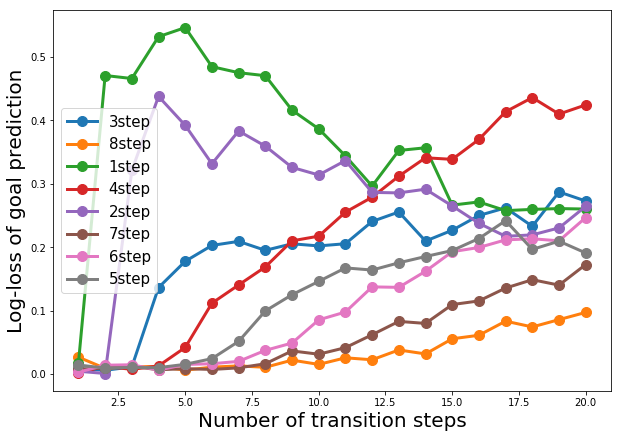

In [18]:
plt.figure(figsize=(10,7))
pairs = ((n, g) for n, g in goal_score_dict.items() if n != 'wfeatures')
for name, goalscore in pairs:
    plt.plot(np.arange(1, max_val_steps +1), goalscore, label=name, linewidth=3, linestyle='-', marker='o', markersize=10)
    plt.legend(fontsize=15)
    # NOTES TO ADD: THIS IS WITH PREDICTION ALWAYS STARTING AT 5, AND REFLECTS THE FACT THAT AS X DECREASES, ACCURACY DROPS
    # BUT CHART WITHOUT ALWAYS STARTING AT 5 SHOWS OPPOSITE! BECAUSE IT'S DOING WELL CLOSE TO EDGES
    plt.xlabel("Number of transition steps", size=20)
    plt.ylabel("Log-loss of goal prediction", size=20)
plt.savefig(os.path.join("figures",basename + 'rewpred.svg'))
plt.savefig(os.path.join("figures",basename + 'rewpred.png'))

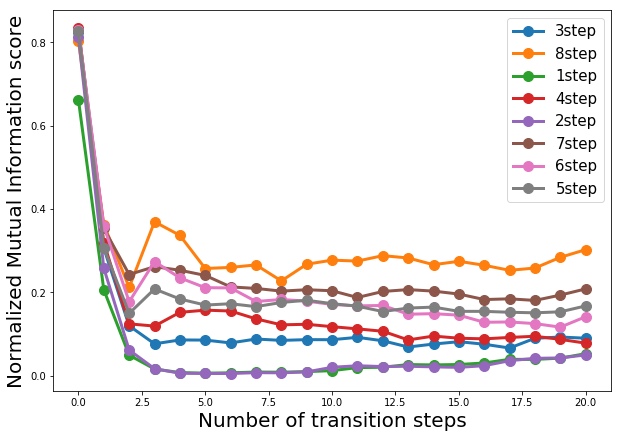

In [19]:
plt.figure(figsize=(10,7))
pairs = ((n, g) for n, g in clustering_score_dict.items() if n[-5:] != 'wfeatures')
for name, vscore in pairs:
    plt.plot(np.arange(max_val_steps + 1), vscore, label=name, linewidth=3, linestyle='-', marker='o', markersize=10)
    plt.legend(fontsize=15)
    # NOTES TO ADD: THIS IS WITH PREDICTION ALWAYS STARTING AT 5, AND REFLECTS THE FACT THAT AS X DECREASES, ACCURACY DROPS
    # BUT CHART WITHOUT ALWAYS STARTING AT 5 SHOWS OPPOSITE! BECAUSE IT'S DOING WELL CLOSE TO EDGES
    plt.xlabel("Number of transition steps", size=20)
    plt.ylabel("Normalized Mutual Information score", size=20)
plt.savefig(os.path.join("figures",basename + 'smi.svg'))
plt.savefig(os.path.join("figures",basename + 'smi.png'))

In [71]:
[n for n in clustering_score_dict.keys()]

['5step',
 '3step_nogb',
 '4step',
 '4step_nogb',
 'wfeatures',
 '2step',
 '1step',
 '6step',
 '2step_nogb',
 '6step_nogb',
 '3step',
 '5step_nogb',
 '1step_nogb']

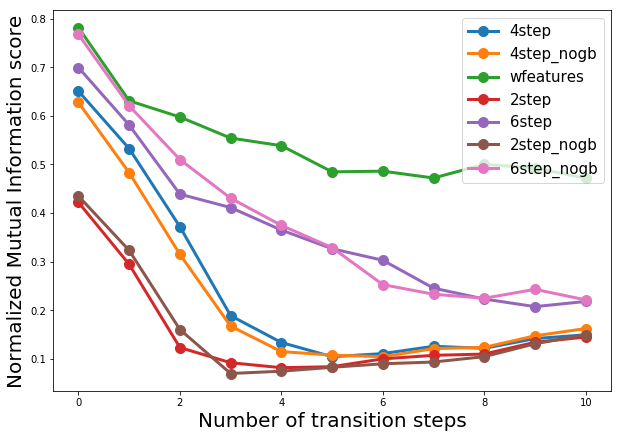

In [78]:
plt.figure(figsize=(10,7))
pairs = ((n, g) for n, g in clustering_score_dict.items() if n[0] not in '135')
for name, vscore in pairs:
    plt.plot(np.arange(max_val_steps + 1), vscore, label=name, linewidth=3, linestyle='-', marker='o', markersize=10)
    plt.legend(fontsize=15)
    # NOTES TO ADD: THIS IS WITH PREDICTION ALWAYS STARTING AT 5, AND REFLECTS THE FACT THAT AS X DECREASES, ACCURACY DROPS
    # BUT CHART WITHOUT ALWAYS STARTING AT 5 SHOWS OPPOSITE! BECAUSE IT'S DOING WELL CLOSE TO EDGES
    plt.xlabel("Number of transition steps", size=20)
    plt.ylabel("Normalized Mutual Information score", size=20)
plt.savefig('figures/smi_gbvarying.svg')
plt.savefig('figures/smi_gbvarying.png')